<a href="https://colab.research.google.com/github/Rig12332113/ML_practice/blob/main/practice2%3Aclaasification/machine_learning_practice2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Get data

In [1]:
!pip install --upgrade gdown

# Main link
# !gdown --id '1N1eVIDe9hKM5uiNRGmifBlwSDGiVXPJe' --output libriphone.zip
!gdown --id '1qzCRnywKh30mTbWUEjXuNT2isOCAPdO1' --output libriphone.zip

!unzip -q libriphone.zip
!ls libriphone

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1qzCRnywKh30mTbWUEjXuNT2isOCAPdO1
From (redirected): https://drive.google.com/uc?id=1qzCRnywKh30mTbWUEjXuNT2isOCAPdO1&confirm=t&uuid=4ea8c2b0-1d17-4d4c-9584-627b9fdf9fae
To: /content/libriphone.zip
100% 384M/384M [00:07<00:00, 49.1MB/s]
feat  test_split.txt  train_labels.txt	train_split.txt


# 2. Data preprocessing

In [2]:
import os
import torch
from tqdm import tqdm

def load_feat(path):
    feat = torch.load(path)
    return feat

def shift(x, n):
    if n < 0:
        left = x[0].repeat(-n, 1)
        right = x[:n]
    elif n > 0:
        right = x[-1].repeat(n, 1)
        left = x[n:]
    else:
        return x

    return torch.cat((left, right), dim=0)

def concat_feat(x, concat_n):
    assert concat_n % 2 == 1 # n must be odd
    if concat_n < 2:
        return x
    seq_len, feature_dim = x.size(0), x.size(1)
    x = x.repeat(1, concat_n)
    x = x.view(seq_len, concat_n, feature_dim).permute(1, 0, 2) # concat_n, seq_len, feature_dim
    mid = (concat_n // 2)
    for r_idx in range(1, mid+1):
        x[mid + r_idx, :] = shift(x[mid + r_idx], r_idx)
        x[mid - r_idx, :] = shift(x[mid - r_idx], -r_idx)

    return x.permute(1, 0, 2).view(seq_len, concat_n * feature_dim)

def preprocess_data(split, feat_dir, phone_path, concat_nframes, train_ratio=0.8, random_seed=1213):
    class_num = 41 # NOTE: pre-computed, should not need change

    if split == 'train' or split == 'val':
        mode = 'train'
    elif split == 'test':
        mode = 'test'
    else:
        raise ValueError('Invalid \'split\' argument for dataset: PhoneDataset!')

    label_dict = {}
    if mode == 'train':
        for line in open(os.path.join(phone_path, f'{mode}_labels.txt')).readlines():
            line = line.strip('\n').split(' ')
            label_dict[line[0]] = [int(p) for p in line[1:]]

        # split training and validation data
        usage_list = open(os.path.join(phone_path, 'train_split.txt')).readlines()
        random.seed(random_seed)
        random.shuffle(usage_list)
        train_len = int(len(usage_list) * train_ratio)
        usage_list = usage_list[:train_len] if split == 'train' else usage_list[train_len:]

    elif mode == 'test':
        usage_list = open(os.path.join(phone_path, 'test_split.txt')).readlines()

    usage_list = [line.strip('\n') for line in usage_list]
    print('[Dataset] - # phone classes: ' + str(class_num) + ', number of utterances for ' + split + ': ' + str(len(usage_list)))

    max_len = 3000000
    X = torch.empty(max_len, 39 * concat_nframes)
    if mode == 'train':
        y = torch.empty(max_len, dtype=torch.long)

    idx = 0
    for i, fname in tqdm(enumerate(usage_list)):
        feat = load_feat(os.path.join(feat_dir, mode, f'{fname}.pt'))
        cur_len = len(feat)
        feat = concat_feat(feat, concat_nframes)
        if mode == 'train':
          label = torch.LongTensor(label_dict[fname])

        X[idx: idx + cur_len, :] = feat
        if mode == 'train':
          y[idx: idx + cur_len] = label

        idx += cur_len

    X = X[:idx, :]
    if mode == 'train':
      y = y[:idx]

    print(f'[INFO] {split} set')
    print(X.shape)
    if mode == 'train':
      print(y.shape)
      return X, y
    else:
      return X


# 2-1: random parameter setting

In [3]:
import numpy as np
import torch
import random

def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# 3. Dataset


In [4]:
import torch
from torch.utils.data import Dataset

class LibriDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = X
        if y is not None:
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)


# 5. Model and training

In [80]:
# data parameter
concat_nframes = 11
training_ratio = 0.8

# training parameter
RANDOM_SEED = 42
same_seeds(RANDOM_SEED)
BATCH_SIZE = 256
EPOCHS = 10
learning_rate = 0.001

# model parameter
INPUT_DIM = 39 * concat_nframes
HIDDEN_DIM = 512
OUTPUT_DIM = 41


In [81]:
from torch.utils.data import DataLoader
import gc

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE: {device}')

# preprocess data
train_X, train_y = preprocess_data(split='train', feat_dir='./libriphone/feat', phone_path='./libriphone', concat_nframes=concat_nframes, train_ratio=training_ratio, random_seed=RANDOM_SEED)
val_X, val_y = preprocess_data(split='val', feat_dir='./libriphone/feat', phone_path='./libriphone', concat_nframes=concat_nframes, train_ratio=training_ratio, random_seed=RANDOM_SEED)

# get dataset
train_set = LibriDataset(train_X, train_y)
val_set = LibriDataset(val_X, val_y)

# remove raw feature to save memory
del train_X, train_y, val_X
gc.collect()

# get dataloader
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

DEVICE: cuda
[Dataset] - # phone classes: 41, number of utterances for train: 2743


2743it [00:06, 443.40it/s]


[INFO] train set
torch.Size([1689304, 429])
torch.Size([1689304])
[Dataset] - # phone classes: 41, number of utterances for val: 686


686it [00:01, 515.59it/s]


[INFO] val set
torch.Size([427490, 429])
torch.Size([427490])


In [82]:
import torch.nn as nn
class classifier(nn.Module):
    def __init__(self, input_dimension, hidden_dimension, output_dimension):
        super(classifier, self).__init__()
        self.stack = nn.Sequential(
            nn.BatchNorm1d(input_dimension),
            nn.Linear(input_dimension, hidden_dimension),
            nn.BatchNorm1d(hidden_dimension),
            nn.Linear(hidden_dimension, hidden_dimension),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dimension),
            nn.Linear(hidden_dimension, hidden_dimension),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dimension),
            nn.Linear(hidden_dimension, hidden_dimension),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(hidden_dimension, output_dimension)
        )
    def forward(self, x):
        return self.stack(x)

model_0 = classifier(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr= learning_rate)

In [83]:
best_acc = 0.0
for epoch in range(EPOCHS):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    # training
    for batchNum, (X, y) in enumerate(tqdm(train_loader)):
        model_0.train()
        X, y = X.to(device), y.to(device)

        # forward
        logits = model_0(X)
        pred = torch.argmax(logits, dim=1)

        # loss
        loss = loss_fn(logits, y)
        train_loss += loss.item()

        # accuracy
        train_acc += (pred == y).sum().item()

        # zero grad
        optimizer.zero_grad()

        # backward
        loss.backward()

        # update parameters
        optimizer.step()

    # validation
    model_0.eval()
    with torch.inference_mode():
        for batchNum, (X, y) in enumerate(tqdm(val_loader)):
            X, y = X.to(device), y.to(device)

            # forward
            logits = model_0(X)
            pred = torch.argmax(logits, 1) # get the index of the class with the highest probability

            # loss
            loss = loss_fn(logits, y)
            val_loss += loss.item()

            # accuracy
            train_acc += (pred == y).sum().item()
            val_acc += (pred == y).sum().item()

    print(f'[{epoch+1:03d}/{epoch:03d}] Train Acc: {train_acc/len(train_set):3.5f} Loss: {train_loss/len(train_loader):3.5f} | Val Acc: {val_acc/len(val_set):3.5f} loss: {val_loss/len(val_loader):3.5f}')
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model_0.state_dict(), 'best.ckpt')

100%|██████████| 1670/1670 [00:05<00:00, 302.81it/s]


[001/000] Train Acc: 0.75987 Loss: 1.29698 | Val Acc: 0.63791 loss: 1.14527


100%|██████████| 1670/1670 [00:04<00:00, 359.16it/s]


[002/001] Train Acc: 0.81248 Loss: 1.12186 | Val Acc: 0.65807 loss: 1.07894


100%|██████████| 1670/1670 [00:05<00:00, 310.48it/s]


[003/002] Train Acc: 0.83133 Loss: 1.05951 | Val Acc: 0.66543 loss: 1.05272


100%|██████████| 1670/1670 [00:04<00:00, 337.38it/s]


[004/003] Train Acc: 0.84415 Loss: 1.01894 | Val Acc: 0.67167 loss: 1.03446


100%|██████████| 1670/1670 [00:04<00:00, 341.57it/s]


[005/004] Train Acc: 0.85344 Loss: 0.98936 | Val Acc: 0.67571 loss: 1.01775


100%|██████████| 1670/1670 [00:05<00:00, 302.23it/s]


[006/005] Train Acc: 0.86035 Loss: 0.96696 | Val Acc: 0.67805 loss: 1.01316


100%|██████████| 1670/1670 [00:04<00:00, 360.48it/s]


[007/006] Train Acc: 0.86586 Loss: 0.94848 | Val Acc: 0.67985 loss: 1.00717


100%|██████████| 1670/1670 [00:05<00:00, 327.04it/s]


[008/007] Train Acc: 0.87115 Loss: 0.93371 | Val Acc: 0.68319 loss: 1.00006


100%|██████████| 1670/1670 [00:05<00:00, 320.06it/s]


[009/008] Train Acc: 0.87429 Loss: 0.92011 | Val Acc: 0.68288 loss: 0.99911


100%|██████████| 1670/1670 [00:04<00:00, 358.11it/s]

[010/009] Train Acc: 0.87760 Loss: 0.90900 | Val Acc: 0.68477 loss: 0.99790


# 6. Evaluate

In [49]:
model_Eval = classifier(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
model_Eval.load_state_dict(torch.load('best.ckpt'))

<All keys matched successfully>

In [50]:
from torch import tensor
model_Eval.eval()
outcome = torch.zeros(0).to(device)
with torch.inference_mode():
    for batchNum, (X, y) in enumerate(tqdm(val_loader)):
        X, y = X.to(device), y.to(device)

        # forward
        logits = model_Eval(X)
        outcome = torch.cat((outcome, torch.argmax(logits, dim = 1)), 0)

100%|██████████| 1670/1670 [00:03<00:00, 472.56it/s]


In [56]:
outcome

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

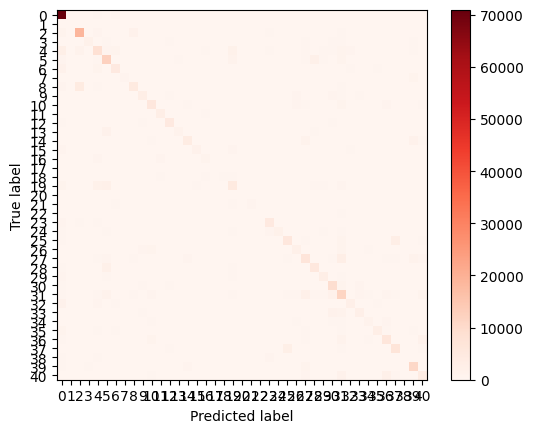

In [57]:
# Confusion Matrix is hard to tell the performance of the model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(val_y, outcome.cpu().numpy())
display = ConfusionMatrixDisplay(cm)
display.plot(include_values=False, cmap='Reds')
plt.show()

# Some Result
- 1. linear plus relu --> accuracy = 0.55068
- 2. increase layers --> accuracy = 0.55112 (slightly increase)
- 3. try batch normalization --> accuracy = 0.55707
- 4. try dropout and more normalization --> accuracy = 0.56188
- 5. more parameter (hidden_dimension * 2) --> accuracy = 0.56563
- 6. adjust data preprocessing (concatenate to 7) --> accuracy = 0.65069 --> (concatenate to 11) accuracy = 0.68477


# Reference:
- sample code: https://colab.research.google.com/drive/1wzeiVy2g7HpSjlidUr0Gi50NnHBWTkvN#scrollTo=Bg-GRd7ywdrL